In [1]:
import geopandas as gpd
import pandas as pd


from pathlib import Path

In [2]:
USE_CRS = "EPSG:5349"

In [3]:
dat = gpd.read_file(
    "/home/nissim/Documents/dev/ciut-inundaciones/data/la_plata_pelig_2023_datos_originales.geojson"
)
dat = dat.to_crs(USE_CRS)

In [4]:
# convert column names to lowercase
dat.columns = dat.columns.str.lower()

# filter out rows where peligrosid is 'muy baja a nula'
dat = dat[dat["peligrosid"] != "Muy Baja a Nula"]

In [7]:


import rasterio
from rasterio import features
import numpy as np
from shapely.geometry import shape

# Define the target raster properties
bounds = dat.total_bounds  # (minx, miny, maxx, maxy)
resolution = 100  # meters - adjust as needed
width = int(np.ceil((bounds[2] - bounds[0]) / resolution))
height = int(np.ceil((bounds[3] - bounds[1]) / resolution))


# Create a mapping from peligrosid values to numeric codes
peligrosid_mapping = {"alta": 3, "media": 2, "baja": 1}

# First rasterize at 10m resolution (original data resolution)
resolution_original = 10  # meters
width_original = int(np.ceil((bounds[2] - bounds[0]) / resolution_original))
height_original = int(np.ceil((bounds[3] - bounds[1]) / resolution_original))

transform_original = rasterio.transform.from_bounds(
    west=bounds[0],
    south=bounds[1],
    east=bounds[2],
    north=bounds[3],
    width=width_original,
    height=height_original,
)

# Rasterize at original resolution
shapes = (
    (shape(geom), peligrosid_mapping.get(val, 0))
    for geom, val in zip(dat.geometry, dat["peligrosid"])
)

raster_10m = features.rasterize(
    shapes=shapes,
    out_shape=(height_original, width_original),
    transform=transform_original,
    fill=0,
    dtype=np.uint8,
)

# Now resample to 100m using majority voting
from rasterio.warp import reproject, Resampling

# Calculate target dimensions
width_100m = int(np.ceil((bounds[2] - bounds[0]) / resolution))
height_100m = int(np.ceil((bounds[3] - bounds[1]) / resolution))

transform_100m = rasterio.transform.from_bounds(
    west=bounds[0],
    south=bounds[1],
    east=bounds[2],
    north=bounds[3],
    width=width_100m,
    height=height_100m,
)

# Resample using majority voting
raster_100m = np.zeros((height_100m, width_100m), dtype=np.uint8)
reproject(
    source=raster_10m,
    destination=raster_100m,
    src_transform=transform_original,
    src_crs=USE_CRS,
    dst_transform=transform_100m,
    dst_crs=USE_CRS,
    resampling=Resampling.mode,  # This is majority voting
    src_nodata=0,
    dst_nodata=0,
)

(array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], shape=(593, 601), dtype=uint8),
 Affine(np.float64(99.89097184262792), np.float64(0.0), np.float64(7098513.704024811),
        np.float64(0.0), np.float64(-99.90710074458315), np.float64(6139974.26979945)))

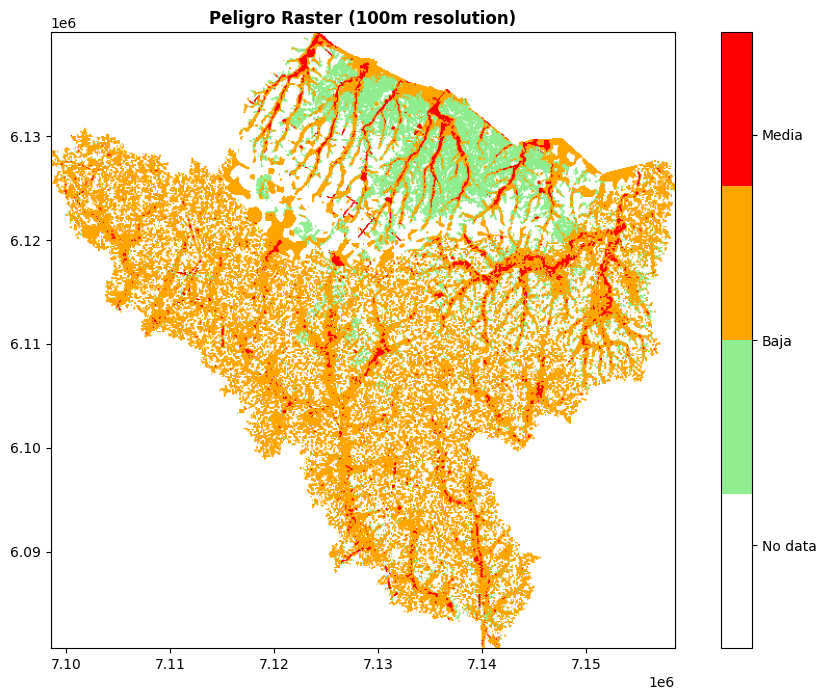

In [8]:
import matplotlib.pyplot as plt
from rasterio.plot import show

# Create a custom colormap
colors = ['white', 'lightgreen', 'orange', 'red']
cmap = plt.cm.colors.ListedColormap(colors)

# Plot using rasterio's show function
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

show(raster_100m, 
     ax=ax, 
     cmap=cmap, 
     transform=transform_100m, 
     title='Peligro Raster (100m resolution)')

# Add colorbar
cbar = plt.colorbar(ax.images[0], ax=ax, ticks=[0.5, 1.5, 2.5, 3.5])
cbar.set_ticklabels(['No data', 'Baja', 'Media', 'Alta'])

plt.show()

In [ ]:
# Save the raster as a GeoTIFF for external viewing
with rasterio.open(
    'peligro_raster_100m.tif',
    'w',
    driver='GTiff',
    height=height_100m,
    width=width_100m,
    count=1,
    dtype=np.uint8,
    crs=USE_CRS,
    transform=transform_100m,
    nodata=0
) as dst:
    dst.write(raster_100m, 1)

In [10]:
# Save the raster as a GeoTIFF for external viewing
with rasterio.open(
    'peligro_raster_10m.tif',
    'w',
    driver='GTiff',
    height=height_original,
    width=width_original,
    count=1,
    dtype=np.uint8,
    crs=USE_CRS,
    transform=transform_original,
    nodata=0
) as dst:
    dst.write(raster_10m, 1)